# Train transformer encoder 

The input of the sequence classifier is a timeseries of a high dimension vector.

Train a encoder transformer from scratch, on sequence classification. Similar to BERT paper, we add a [CLS] token to the sequence start.
Then we learn an embedding on the 10-dimensional feature vector, add positional encoding, and run the data through an encoder stack.
We add a small feed-forward neural network to the final [CLS] token representation, plus a softmax for class prediction.

In [16]:
# Hyper parameters

DATASET = "dataset_career_con_2019.npz"
EPOCHS = 20
D_MODEL = 4
ATTENTION_HEADS = 3
NUM_ENCODERS = 5
BATCH_SIZE = 32
WINDOW_SIZE = 128

POSITIONAL_ENCODING_PERIOD = 5 * WINDOW_SIZE
LR = 0.01
DROPOUT = 0.1
REGULARIZATION = 0.01
KEY_DIM = D_MODEL
DIM_FF = 4 * D_MODEL

CLS = -1

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2

## Transformer implementation

In [18]:
def positional_encoding(length, depth):
    """
    Compute a position encoding, as sinusoidal function.

    Arguments:
      - length: The period for the positional encoding
      - depth: The hidden dimension of each token
    """
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Learn an embedding for dimensionality reduction and add a fix positional encoding.
    """
    def __init__(self, d_model, positional_encoding_period):
        """
        Arguments:
         - d_model: Dimension of token representations
         - positional_encoding_period: The period of the positional encoding
        """
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Dense(d_model) 
        self.pos_encoding = positional_encoding(length=positional_encoding_period, depth=d_model)


    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [20]:
class SelfAttention(tf.keras.layers.Layer):
    """
    Multi head attention + normalization + residual connection.
    """
    def __init__(self, num_heads, key_dim, dropout_rate):
        """
        Arguments:
         - num_heads: The number of attention heads
         - key_dim: The dimensionality of learned keys for self-attention
         - dropout_rate: The dropout rate for multi-head attention
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout_rate)
        self.add = tf.keras.layers.Add()
        self.layernorm = tf.keras.layers.LayerNormalization()


    def call(self, x):
        scores = self.mha(x,x,x)
        # apply normalization before residual connection, as proposed in T5 paper
        norm = self.layernorm(scores)
        sum = self.add([x, norm])
        return sum

In [21]:
class FeedForward(tf.keras.layers.Layer):
    """
    Feed forward neural network + normalization + residual connection.
    """
    def __init__(self, d_model, dff, dropout_rate):
        """
        Arguments:
          - d_model: Dimension of token representations
          - dff: Token dimension between the two dense layers of the feed forward neural network
          - dropout_rate: Dropout after the two dense layers
        """
        super().__init__()
        self.nn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


    def call(self, x):
        nn_output = self.nn(x)
        norm = self.layer_norm(nn_output)
        res = self.add([norm, x])
        return res

In [22]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    A complete encoder layer, including everything from self attention to feed forward neural network.
    """
    def __init__(self, d_model, num_heads, key_dim, dff, dropout_rate):
        """
        Arguments:
          - d_model: Dimension of token representations
          - num_heads: The number of attention heads
          - key_dim: The dimensionality of learned keys for self-attention
          - dff: Token dimension between the two dense layers of the feed forward neural network
          - dropout_rate: Dropout rate in attention heads and in feed forward neural network
        """
        super().__init__()

        self.self_attention = SelfAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout_rate=dropout_rate)

        self.ffn = FeedForward(d_model, dff, dropout_rate)


    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [23]:
class ClassificationHead(tf.keras.layers.Layer):
    """
    Classification head applied to final [CLS] token representation.
    """
    def __init__(self, dff, regularization, dropout_rate, num_classes):
        """
        Arguments:
         - dff: Token dimension between the two dense layers
         - regularization: Regularization is applied after first dense layer
         - dropout_rate: Dropout rate after first dense layer
         - num_classes: The number of classes we need to distinguish
        """
        super().__init__()

        self.first_dense = tf.keras.layers.Dense(dff, activation='relu', kernel_regularizer=l2(regularization))
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.second_dense = tf.keras.layers.Dense(num_classes, activation = 'softmax')


    def call(self, x):
        x = self.first_dense(x)
        x = self.dropout(x)
        x = self.second_dense(x)
        return x

In [24]:
class TransformerEncoder(tf.keras.Model):
    """
    Everything from the embedding, to the encoder stack, to the CLS token classification
    """
    def __init__(self, num_layers, d_model, num_heads, key_dim, dff,
                 dropout_rate, positional_encoding_period, regularization, num_classes):
        """
        Arguments:
          - num_layers: Size of the encoder stack
          - d_model: Dimension of token representations
          - num_heads: The number of attention heads
          - key_dim: The dimensionality of learned keys for self-attention
          - dff: Token dimension between the two dense layers of the feed forward neural network
          - dropout_rate: Dropout used throughout the transformer model
          - positional_encoding_period: The period of the positional encoding
          - regularization: L2 regularization used for classification head
          - num_classes: The number of classes to predict
        """
        super().__init__()

        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(d_model=d_model, positional_encoding_period=positional_encoding_period)
        self.dropout_embedding = tf.keras.layers.Dropout(dropout_rate)
        self.encoders = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         key_dim=key_dim,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.classification_head = ClassificationHead(dff=dff, regularization=regularization,
                                                      dropout_rate=dropout_rate, num_classes=num_classes)
        

    def call(self, x):
        """
        The complete forward path.
        
        Arguments:
            - x: The input sequence of shape (batch size, time steps, features)
        """
        x = self.pos_embedding(x)
        x = self.dropout_embedding(x)
        for i in range(self.num_layers):
            x = self.encoders[i](x)
        # Apply classification head to to final [CLS] token representation
        cls_representation = x[:,0,:]
        prediction = self.classification_head(cls_representation)
        return prediction

## Load data

In [25]:
def load_dataset_split(dataset):
    """
    Load training and test data.
    """
    load_dataset = np.load(dataset, allow_pickle=True)
    x_train = load_dataset['x_train']
    y_train = load_dataset['y_train']
    x_test = load_dataset['x_test']
    y_test = load_dataset['y_test']
    return (x_train,y_train,x_test,y_test)

In [26]:
def add_cls_token(x):
    """
    Add a [CLS] token to each sequence
    """
    cls_event = np.repeat(CLS, repeats = x.shape[2]).reshape(1,-1)
    x = np.insert(x, 0, cls_event, axis=1)
    return x

In [27]:
# load dataset from NPZ file
x_train,y_train,x_test,y_test = load_dataset_split(DATASET)

# add CLS starter token to all sequences
x_train = add_cls_token(x_train)
x_test = add_cls_token(x_test)

## Perform the training

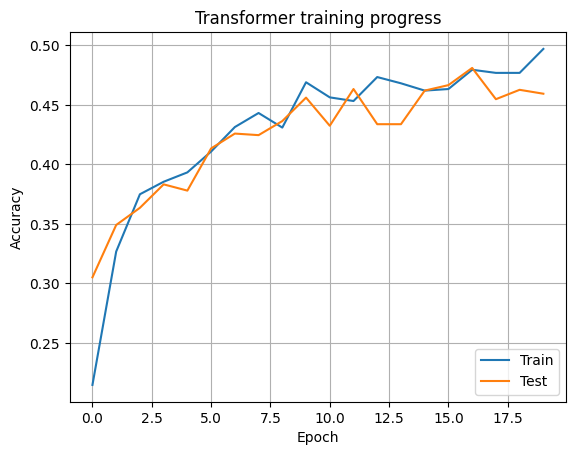

In [28]:
# perform sequence classification training
transformer = TransformerEncoder(
    num_layers = NUM_ENCODERS,
    d_model = D_MODEL,
    num_heads = ATTENTION_HEADS,
    key_dim = KEY_DIM,
    dff = DIM_FF,
    dropout_rate = DROPOUT,
    positional_encoding_period = POSITIONAL_ENCODING_PERIOD,
    regularization = REGULARIZATION,
    num_classes = y_train.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
transformer.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'])
history = transformer.fit(x_train, y_train, epochs = EPOCHS,
                          validation_data = (x_test, y_test),
                          batch_size = BATCH_SIZE,
                          verbose=0)

# draw training progress
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transformer training progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.grid(visible=True)
plt.show()